In [71]:
## START OF NOTEBOOK
def print_pred(audio_file, prob, labels):
    if "spoofed" in audio_file.name or int(audio_file.name[-11:-5]) > 25000:
        return (audio_file, sum(prob) / len(prob), 1)
    return (audio_file, sum(prob) / len(prob), 0)

In [72]:
from pathlib import Path
import torchaudio.transforms as T
import torchaudio
import matplotlib.pyplot as plt
import librosa

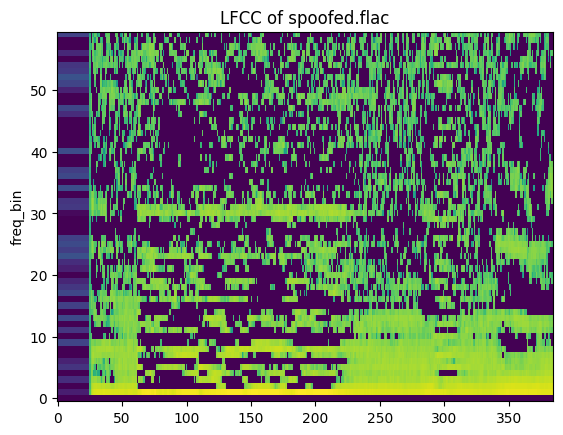

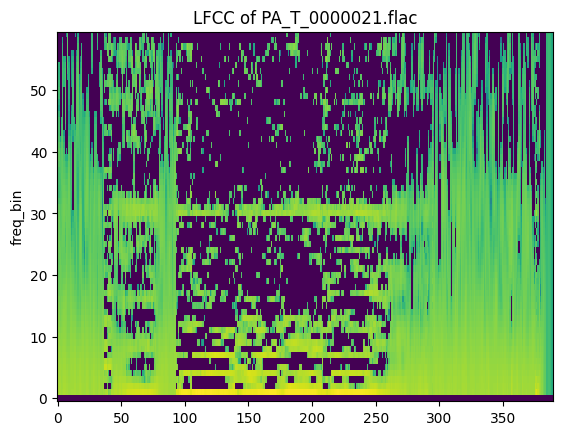

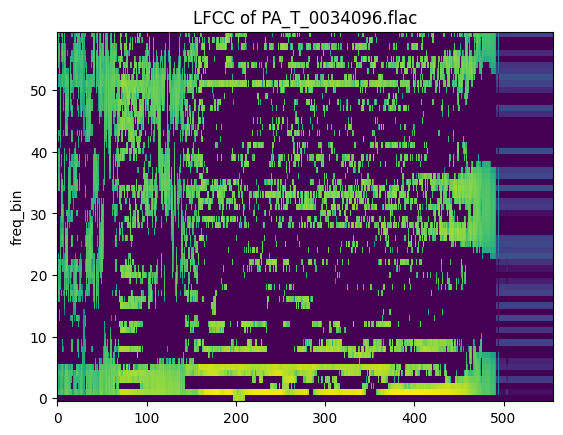

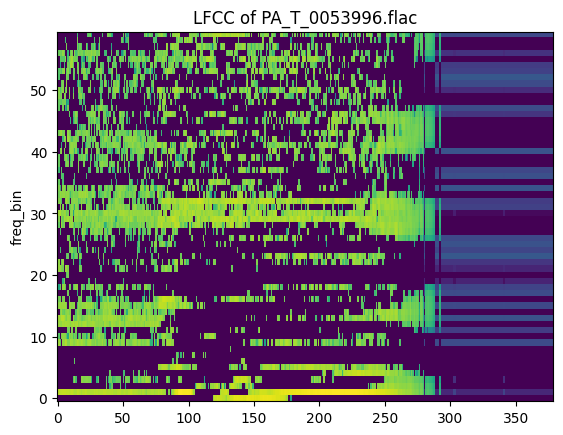

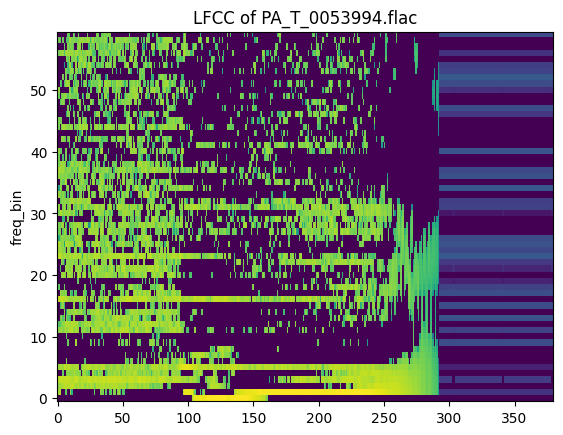

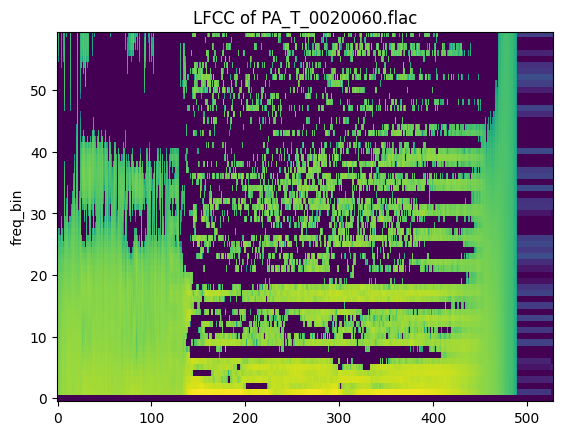

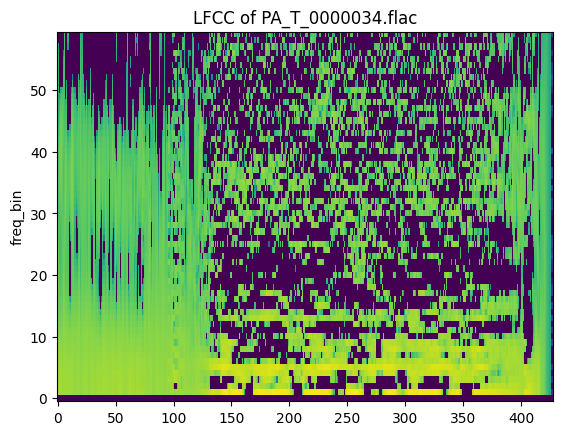

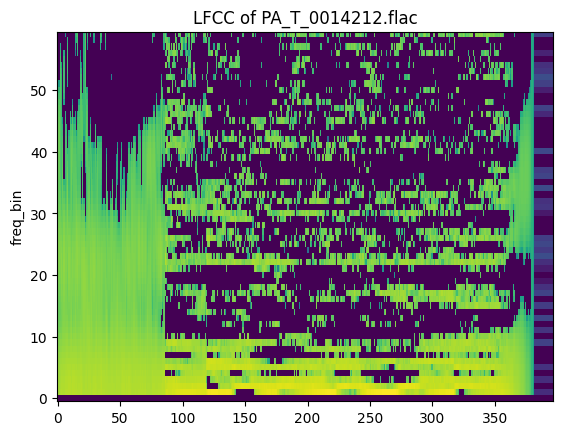

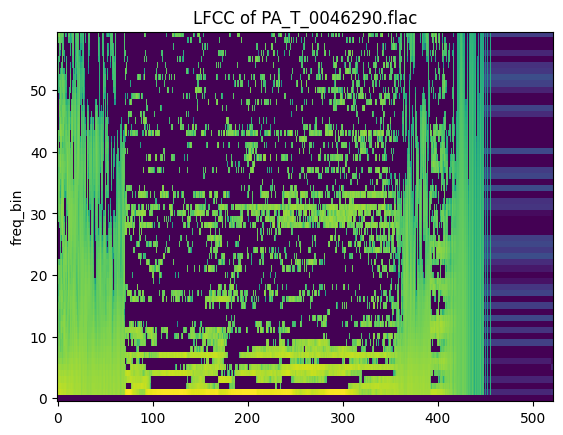

In [73]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )


lfcc = T.LFCC(
    sample_rate=16000, n_lfcc=60, speckwargs={"n_fft": 512, "hop_length": 160}
)
for file in Path("./test_audios").iterdir():
    audio, sr = torchaudio.load(str(file))
    if sr != 16000:
        resampler = T.Resample(orig_freq=sr, new_freq=16000)
        audio = resampler(audio)
    lfcc_feat = lfcc(audio)
    plot_spectrogram(lfcc_feat[0], title=f"LFCC of {file.name}")

## LFCC


In [74]:
from pathlib import Path
import torch

from LFCC_LCNN.audio_dataset import AudioDataset, Config
from LFCC_LCNN.model import LCNN

In [75]:
config = Config()
audio_list = []
audio_path = Path("./test_audios")

model = LCNN(
    sample_rate=config.sr,
    n_lfcc=config.n_lfcc,
    n_fft=config.n_fft,
    hop_length=config.hop_length,
)
model.load_state_dict(
    torch.load("./LFCC_LCNN/checkpoints/best_model.pth", map_location="cpu")
)
model.eval()

LCNN(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxFeatureMap2D()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): MaxFeatureMap2D()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxFeatureMap2D()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
    (11): MaxFeatureMap2D()
    (12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): MaxFeatureMap2D()
    (15): MaxPool2d(kernel_size

In [76]:
for audio_file in audio_path.iterdir():
    audio_list.append((str(audio_file), "bonafide"))
    dataset = AudioDataset(audio_list, config)
    probabilities = []
    labels = []

    for i in range(len(dataset)):
        input_tensor, label = dataset[i]
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.nn.functional.softmax(output, dim=1)
            probability, label = torch.max(prediction, dim=1)
            probabilities.append(probability.item())
            labels.append(label.item())

    audio_file, avg_prob, final_label = print_pred(audio_file, probabilities, labels)

    print(
        f"Audio File: {audio_file.name}, Probability: {avg_prob}, Label: {final_label} = {config.idx2class[final_label]}"
    )

100%|██████████| 1/1 [00:00<00:00, 365.45it/s]


Audio File: spoofed.flac, Probability: 0.805875301361084, Label: 1 = spoof


100%|██████████| 2/2 [00:00<00:00, 423.71it/s]


Audio File: PA_T_0000021.flac, Probability: 0.8007135192553202, Label: 0 = bonafide


100%|██████████| 3/3 [00:00<00:00, 297.39it/s]


Audio File: PA_T_0034096.flac, Probability: 0.8908846378326416, Label: 1 = spoof


100%|██████████| 4/4 [00:00<00:00, 468.04it/s]


Audio File: PA_T_0053996.flac, Probability: 0.914155866418566, Label: 1 = spoof


100%|██████████| 5/5 [00:00<00:00, 518.26it/s]


Audio File: PA_T_0053994.flac, Probability: 0.928308276569142, Label: 1 = spoof


100%|██████████| 6/6 [00:00<00:00, 497.87it/s]


Audio File: PA_T_0020060.flac, Probability: 0.9440901523286646, Label: 0 = bonafide


100%|██████████| 7/7 [00:00<00:00, 429.51it/s]


Audio File: PA_T_0000034.flac, Probability: 0.9493061900138855, Label: 0 = bonafide


100%|██████████| 8/8 [00:00<00:00, 419.62it/s]


Audio File: PA_T_0014212.flac, Probability: 0.9545221349288677, Label: 0 = bonafide


100%|██████████| 9/9 [00:00<00:00, 425.00it/s]


Audio File: PA_T_0046290.flac, Probability: 0.9473549618440515, Label: 1 = spoof


## Transformer


In [77]:
from pathlib import Path
import torch

from Transformer.audio_dataset import AudioDataset, Config
from Transformer.model import AudioSpoofTransformer

In [78]:
config = Config()
audio_list = []
audio_path = Path("./test_audios")

model = AudioSpoofTransformer(config)
model.load_state_dict(
    torch.load("./Transformer/checkpoints/best_model.pth", map_location="cpu")
)
model.eval()

AudioSpoofTransformer(
  (input_proj): Linear(in_features=60, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pos_enc): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=512, out_features=2, bias=True)
)

In [79]:
for audio_file in audio_path.iterdir():
    audio_list.append((str(audio_file), "bonafide"))
    dataset = AudioDataset(audio_list, config)
    probabilities = []
    labels = []

    for i in range(len(dataset)):
        input_tensor, label = dataset[i]
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.nn.functional.softmax(output, dim=1)
            probability, label = torch.max(prediction, dim=1)
            probabilities.append(probability.item())
            labels.append(label.item())

    audio_file, avg_prob, final_label = print_pred(audio_file, probabilities, labels)
    print(
        f"Audio File: {audio_file.name}, Probability: {avg_prob}, Label: {final_label} = {config.idx2class[final_label]}"
    )

100%|██████████| 1/1 [00:00<00:00, 247.63it/s]


Audio File: spoofed.flac, Probability: 0.8843128283818563, Label: 1 = spoof


100%|██████████| 2/2 [00:00<00:00, 357.77it/s]


Audio File: PA_T_0000021.flac, Probability: 0.8318261404832205, Label: 0 = bonafide


100%|██████████| 3/3 [00:00<00:00, 361.09it/s]


Audio File: PA_T_0034096.flac, Probability: 0.9078008153221824, Label: 1 = spoof


100%|██████████| 4/4 [00:00<00:00, 437.91it/s]


Audio File: PA_T_0053996.flac, Probability: 0.9275522742952619, Label: 1 = spoof


100%|██████████| 5/5 [00:00<00:00, 366.32it/s]


Audio File: PA_T_0053994.flac, Probability: 0.9119563733830172, Label: 1 = spoof


100%|██████████| 6/6 [00:00<00:00, 329.02it/s]


Audio File: PA_T_0020060.flac, Probability: 0.9116528684442694, Label: 0 = bonafide


100%|██████████| 7/7 [00:00<00:00, 381.82it/s]


Audio File: PA_T_0000034.flac, Probability: 0.8949886170717386, Label: 0 = bonafide


100%|██████████| 8/8 [00:00<00:00, 399.13it/s]


Audio File: PA_T_0014212.flac, Probability: 0.9058491299892294, Label: 0 = bonafide


100%|██████████| 9/9 [00:00<00:00, 329.44it/s]


Audio File: PA_T_0046290.flac, Probability: 0.9126327283242169, Label: 1 = spoof
